### A full training loop

We will now look at a 2-class classification problem with a generated toy-dataset.
The data will be stored inside a PyTorch `Dataset` subclass, which will provide you with some utilities like automatic shuffling and batching for the training loop, if paired with `DataLoader`.

The 2 classes are two normal distributions with different means.

In [3]:
%pip install matplotlib 
#install using pip
#%conda install -y matplotlib # or install using conda

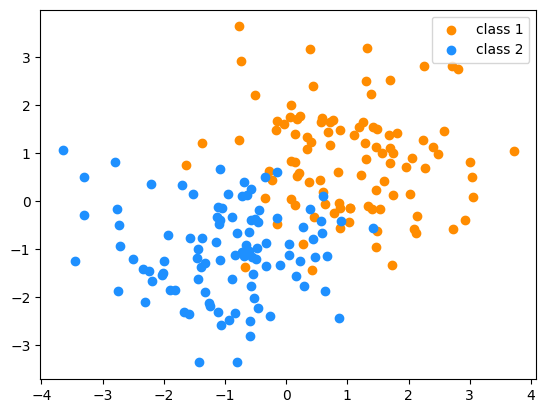

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

class TwoClassDataset(Dataset):
    def __init__(self):
        # create synthetic dataset
        # 创建100个二维特征向量，每个向量的两个分量都服从均值为1，标准差为1的正态分布。
        # torch.normal 是 PyTorch 中用于生成正态分布（也称为高斯分布）随机数的函数。
        # 它可以用来创建服从特定均值和标准差的随机张量。
        self.features_a = torch.normal(mean=1., std=1.0, size=(100,2))
        # 为第一个类别创建100个标签，全部设为0。
        self.labels_a = torch.zeros(100, dtype=torch.long)
        self.features_b = torch.normal(mean=-1.0, std=1.0, size=(100,2))
        self.labels_b = torch.ones(100, dtype=torch.long)

        self.data = torch.cat((self.features_a, self.features_b), dim=0) # X: 200 x 2 matrix : [x1,x2]
        self.labels = torch.cat((self.labels_a, self.labels_b), dim=0) # Y: binary vector of length 200: 0: class A, 1: class B
    '''这段代码创建了一个简单的二分类数据集
    其中，self.features_a 和 self.features_b 分别是两个类别的特征向量，
    self.labels_a 和 self.labels_b 分别是两个类别的标签，
    self.data 是所有样本的特征向量，self.labels 是所有样本的标签。'''
    def __len__(self):
        #size() 是PyTorch张量的一个方法，用于获取张量的维度大小。
        #dim=0 指定我们要获取第0维（即第一个维度）的大小。
        #返回数据集中样本的总数。
        #在这个例子中，它返回 self.data 张量的行数，也就是数据集中的样本数量。
        return self.data.size(dim=0)
    
    def __getitem__(self, index):
        # 它返回一个包含两个元素的元组
        # self.data[index]：给定索引处样本的特征向量。
        # self.labels[index]：给定索引处样本对应的标签。
        return self.data[index], self.labels[index]
    
train_data = TwoClassDataset()

# plot both classes
fig, ax = plt.subplots()
# [:,0] 是 Python 中的切片操作，特别常用于 NumPy 数组和 PyTorch 张量。
# : 表示选择所有行；0 表示选择第一列（因为 Python 的索引从 0 开始）
# train_data.features_a[:,0]：提供所有 class 1 样本的第一个特征值作为 x 坐标。
# train_data.features_a[:,1]：提供所有 class 1 样本的第二个特征值作为 y 坐标。
ax.scatter(train_data.features_a[:,0], train_data.features_a[:,1], label="class 1", c="darkorange")
ax.scatter(train_data.features_b[:,0], train_data.features_b[:,1], label="class 2", c="dodgerblue")
ax.legend()
plt.show()

In [5]:
print("first sample input, label:", train_data[0])

first sample input, label: (tensor([0.3350, 1.0730]), tensor(0))


The data loader can shuffle your dataset for each epoch (which you should definitely do to keep mini-batches representative) and also automatically groups your single samples together into matrices for a mini-batch (the first dimension will always be the batch dimension, e.g. if your data point has size $3$, then a batch of size 25 would have size $25 \times 3$ （这意味着有25 个样本，每个样本有 3 个特征）.

Take a look at the basics about dataloaders and datasets: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

How can we create a DataLoader for our `TwoClassDataset` with a batch size of 5 and shuffling enabled?
- Print a sample from the dataset
- Print the training data samples and labels separately

In [6]:
# 创建 DataLoader
# 这意味着每个批次将包含5个样本，并且数据在每个 epoch 都会被打乱
loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
# get one single batch, in different order each time an iterator is created
# 使用 next(iter(train_loader)) 获取第一个批次
# iter() 函数将 train_loader 转换为一个迭代器。
# next() 函数用于从迭代器中获取下一个元素。
# 当应用于 DataLoader 的迭代器时，它会返回下一个批次。
# 快速访问：这种方法允许我们快速获取第一个批次，而不需要设置一个完整的循环。
# 单次获取：我们只想查看一个批次的样本，而不是遍历整个数据集。
batch_samples, batch_labels = next(iter(loader))
print(batch_samples) # samples grouped together to a 5 x 2 matrix (x1, x2)
print(batch_labels)  # labels grouped together to a 5-dimensional vector 

tensor([[-2.2040,  0.3620],
        [-1.0439, -0.1404],
        [ 0.4030,  1.2194],
        [-1.0868,  0.6687],
        [-0.7706,  3.6335]])
tensor([1, 1, 0, 1, 0])


We're creating a new clasifier for our problem, the input size is 2 and the output size is 2 because we want to do multi-class classification (for 2 classes, a sigmoid and a single output would also work).
The activation function is a ReLU (rectified linear unit). It is piecewise linear: $relu(x) = max(0, x)$

In [11]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.layer1 = torch.nn.Linear(2,6)
        self.layer2 = torch.nn.Linear(6,6)
        self.layer3 = torch.nn.Linear(6,2)
    def forward(self, x):
        # define the forward pass
        y = torch.relu(self.layer1(x))
        y = torch.relu(self.layer2(y))
        y = self.layer3(y)
        return y

In [12]:
%pip install tqdm
#%conda install -y tqdm # or install using conda

Note: you may need to restart the kernel to use updated packages.


For the training loop, we need instances of
* the training data (in real applications, also development / test data)
* a loss criterion (e.g. MSE for regression tasks, Cross Entropy for classification)
* an optimizer

We will iterate many times over the full dataset (each iteration is called an *epoch*).
Each epoch is broken up further into mini-batches that can be adapted to fit e.g. your computer's memory constraints.

For each mini-batch, we need to:
* reset the gradients (otherwise, they will accumulate)
* forward the input data to create predictions
* calculate the loss between the predictions and the gold labels
* calculate the gradient of the loss w.r.t. the network weights (backward pass)
* update the network weights using the gradients and the optimizer

Please implement the following steps to complete the training loop:

1. **Reset gradients to 0**
   - Task: Reset the gradients to zero using the optimizer.
   - Variable: `optim`

2. **Access data and labels from batch**
   - Task: Access the input data and labels from the current mini-batch.
   - Variables: `inputs`, `gold_labels`

3. **Perform the forward pass**
   - Task: Perform the forward pass to get the predictions from the model.
   - Variables: `predictions`, `model`

4. **Calculate the loss and perform the backward pass**
   - Task: Calculate the loss and perform the backward pass to compute the gradients.
   - Variables: `loss`, `loss_func`

5. **Update the network weights**
   - Task: Update the network weights using the optimizer.
   - Variable: `optim`

In [13]:
# tqdm是一个Python库，用于在循环或长时间运行的操作中添加进度条
from tqdm import tqdm

# instantiate model, loss criterion and optimizer
classy = Classifier()
loss_func = torch.nn.CrossEntropyLoss()
# 创建优化器，使用随机梯度下降（SGD），学习率为0.01。
# 在每次迭代中，SGD只使用一个或一小批样本来计算梯度，而不是使用整个数据集。
# 根据计算出的梯度，更新模型参数，使其朝着减小损失的方向移动。
optim = torch.optim.SGD(params=classy.parameters(), lr=0.01)

# store epoch metrics
# 创建空列表，用于存储每个epoch的平均准确率和损失。
epoch_accs = []
epoch_losses = []
# 创建数据加载器，每批25个样本，随机打乱数据。
dataloader = DataLoader(dataset=train_data, batch_size=25, shuffle=True)

# epoch loop
# 开始50个epoch的训练循环，使用tqdm显示进度。
for epoch in tqdm(range(50)):
    # 创建空列表，用于存储当前epoch中每个批次的准确率和损失。
    epoch_acc = []
    epoch_loss = []
    
    # mini-batch loop for one epoch
    # 遍历数据加载器中的每个批次
    for batch in dataloader:
        # reset gradients to 0
        # 将梯度重置为零，防止梯度累积
        optim.zero_grad()
        
        # forward pass
        # 从批次中提取输入样本和对应的真实标签
        # 通常，每个批次是一个元组，包含输入数据和对应的标签
        batch_samples = batch[0] # 25 x 2 -> [x1, x2]
        gold_labels = batch[1]   # 25 -> 0: class A, 1: class B
        # 通过模型进行前向传播，得到预测结果
        predictions = classy(batch_samples)
       
        # loss and backward pass
        # 计算损失并进行反向传播，计算梯度
        loss = loss_func(predictions, gold_labels)
        loss.backward()
        
        # update network weights
        # 根据计算的梯度更新模型参数
        optim.step()
        
        # check accuracy (get predicted class for each sample, compare to gold label)
        '''predictions 通常是一个二维张量（tensor）
        形状为 [batch_size, num_classes]，其中 batch_size 是当前批次的样本数
        （例子中是25），num_classes 是分类的类别数（例子中是2）。
        每一行对应一个输入样本。每一列对应一个类别.
        这些值通常不是概率，而是未经过 softmax 处理的原始输出
        要将这些原始分数转换为概率，需要应用 softmax 函数'''
        category_probs = torch.softmax(predictions, dim=1) # sums up to 1 for each sample
        # 要获得最终的类别预测，通常会选择概率最高的类别
        category_labels = torch.argmax(category_probs, dim=1) # extract most likely label
        # 计算批次的平均准确率
        '''category_labels == gold_labels进行元素级的比较，返回一个布尔型张量
        形状：[25]（假设批次大小为25）示例：[True, False, True, True, ...]'''
        '''.float()将布尔型张量转换为浮点型张量
        True 转换为 1.0，False 转换为 0.0。
        形状：仍然是 [25]示例：[1.0, 0.0, 1.0, 1.0, ...]'''
        batch_acc = (category_labels == gold_labels).float().sum(dim=0)/25.0 # avg accuracy for batch
        '''batch_acc 是一个 PyTorch 张量（tensor）;这个张量只包含一个元素，即计算出的批次准确率
        .item() 方法从只包含一个元素的张量中提取该元素的值
        返回一个标准的 Python 数值（如 float 或 int）;例如，0.76 表示 76% 的样本被正确分类'''
        epoch_acc.append(batch_acc.item())
        epoch_loss.append(loss.item())

    # average all metrics across one epoch
    epoch_losses.append(sum(epoch_loss)/len(epoch_loss))
    epoch_accs.append(sum(epoch_acc)/len(epoch_acc))
  


100%|██████████| 50/50 [00:00<00:00, 58.03it/s]


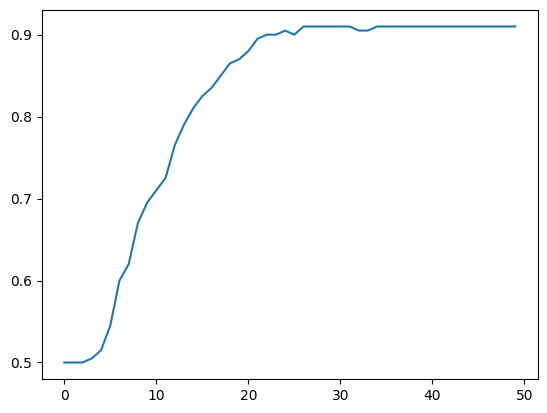

In [14]:
plt.plot(epoch_accs)

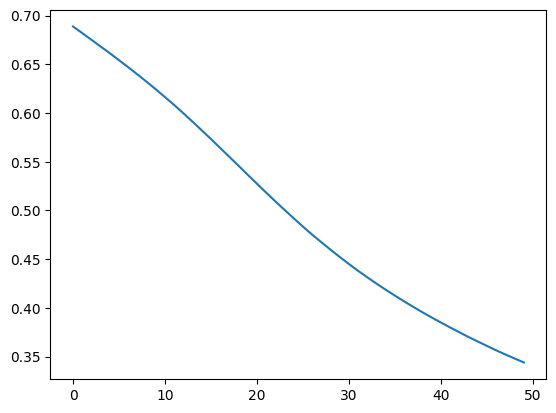

In [15]:
plt.plot(epoch_losses)

We'll visualize the predictions for an unseen test dataset drawn from the same distribution as the training data. Red points mark misclassified samples.

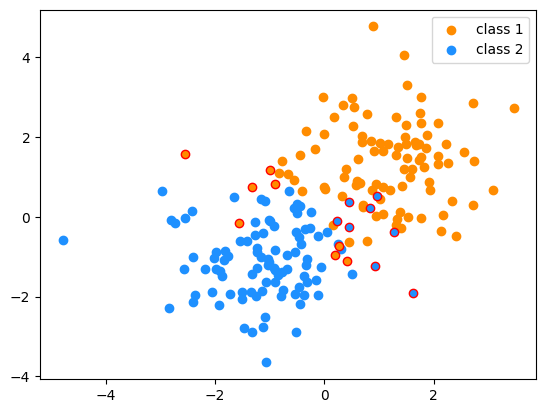

In [ ]:
from matplotlib import pyplot as plt
# 创建一个 TwoClassDataset 类的实例，用于测试数据
test_data = TwoClassDataset()
# 初始化四个空列表，用于存储正确分类和错误分类的样本。
predicted_class_a = []
predicted_class_b = []
missclassified_class_a = []
missclassified_class_b = []
# 遍历测试数据集中的每个样本
for i in range(len(test_data)):
    #获取当前样本的特征 x 和真实标签 label
    x, label = test_data[i]
    # 使用模型 classy 对样本 x 进行预测
    pred = classy(x)
    # 对预测结果应用 softmax 函数，获得概率分布
    probs = torch.softmax(pred, dim=0) # note that the softmax is mathematically not needed since it is a monotonic function
    # 选择概率最高的类别作为预测类别
    class_pred = torch.argmax(probs, dim=0)
    # 根据预测结果和真实标签，将样本分类到相应的列表中
    if label != class_pred:
        if label == 0:
            missclassified_class_a.append(x.unsqueeze(dim=0))
        else:
            missclassified_class_b.append(x.unsqueeze(dim=0))
    else:
        if class_pred == 0:
            predicted_class_a.append(x.unsqueeze(dim=0))
        else:
            predicted_class_b.append(x.unsqueeze(dim=0))
# 将每个列表中的样本连接成一个张量
predicted_class_a = torch.cat(predicted_class_a, dim=0) # concatenates tensor along specified, existing dimension, does not create new dimension
predicted_class_b = torch.cat(predicted_class_b, dim=0) # `stack` is an alternative which creates a new dimension (i.e. we wouldn't have `unsqueeze`d the vectors)
missclassified_class_a = torch.cat(missclassified_class_a, dim=0)
missclassified_class_b = torch.cat(missclassified_class_b, dim=0)

fig, ax = plt.subplots()
ax.scatter(predicted_class_a[:,0], predicted_class_a[:,1], label="class 1", c="darkorange")
ax.scatter(predicted_class_b[:,0], predicted_class_b[:,1], label="class 2", c="dodgerblue")
ax.scatter(missclassified_class_a[:,0], missclassified_class_a[:,1], c="darkorange", edgecolors="r")
ax.scatter(missclassified_class_b[:,0], missclassified_class_b[:,1], c="dodgerblue", edgecolors="r")
ax.legend()
plt.show()